In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/archive (1).zip', 'r') as zip_ref:
     zip_ref.extractall('/content/Alzheimers-disease-detection')

In [ ]:
import pandas as pd
import numpy as np
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [ ]:
default_dir = "/content/Alzheimers-disease-detection/"
root_dir = "./"
#test_dir = default_dir + "test/"
train_dir = default_dir + "Combined Dataset/train"
work_dir = root_dir + "Combined Dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
#copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['No Impairment', 'Mild Impairment', 'Very Mild Impairment', 'Moderate Impairment']


In [ ]:
CLASSES = [ 'No Impairment',
            'Mild Impairment',
            'Very Mild Impairment',
            'Moderate Impairment']

IMG_SIZE = 176

IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [ ]:
train_dataset = image_generator.flow_from_directory(batch_size=5200,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)

Found 10240 images belonging to 4 classes.


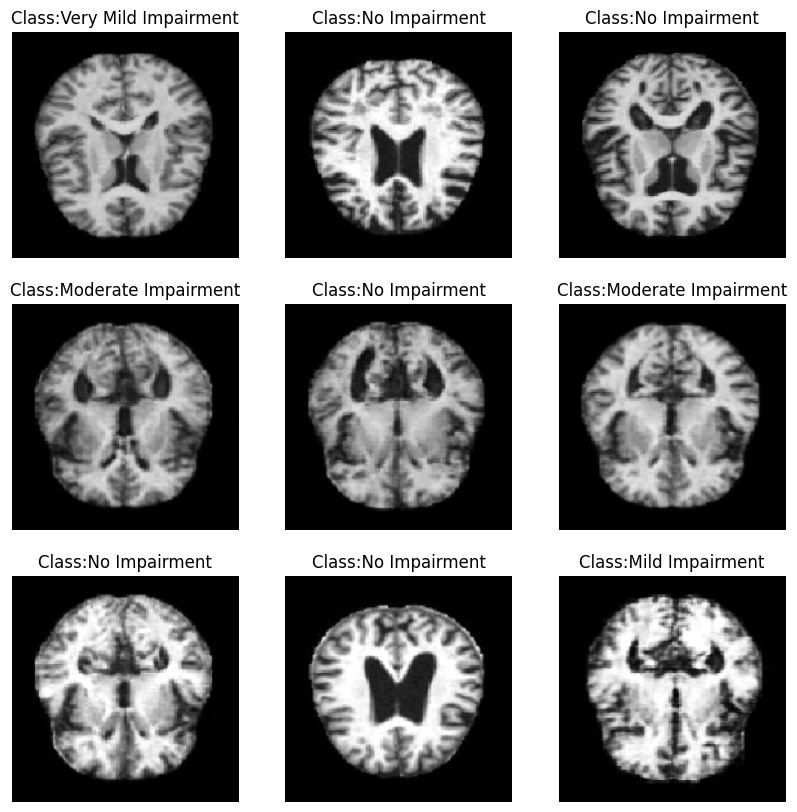

In [ ]:
def show_images(generator,y_pred=None):

    labels =dict(zip([0,1,2,3], CLASSES))
    x,y = next(generator) # Or: x,y = generator.__next__()
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

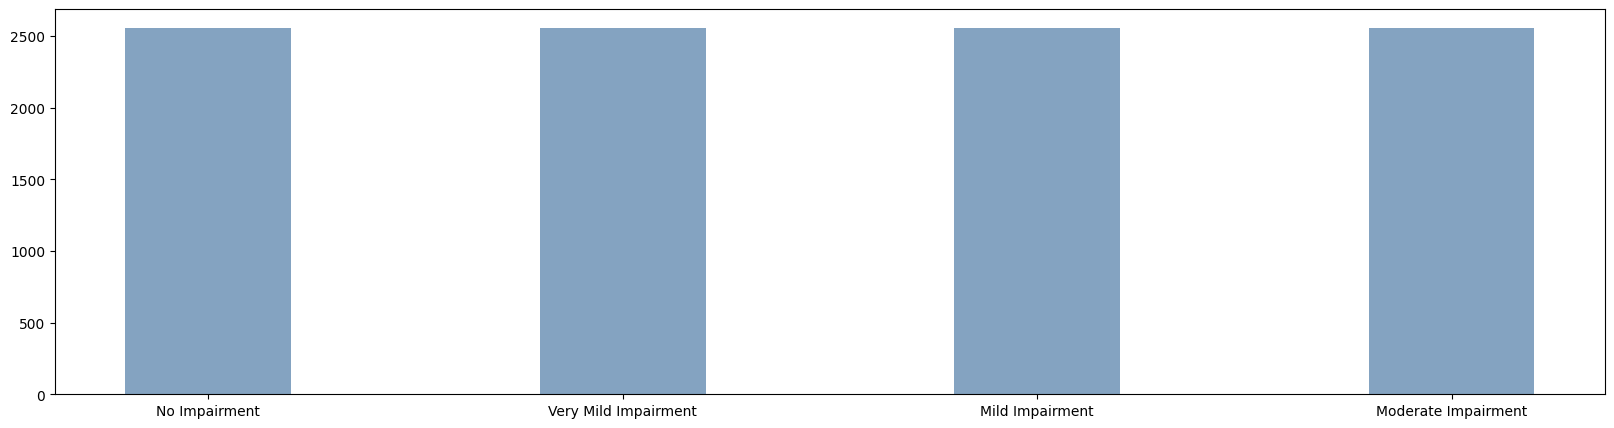

In [ ]:
data = {'No Impairment':      0,
        'Very Mild Impairment': 0,
        'Mild Impairment':     0,
        'Moderate Impairment': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1

keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (20, 5))

plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

In [ ]:
train_data, train_labels = next(train_dataset)
# Or: train_data, train_labels = train_dataset.__next__()

In [ ]:
print(train_data.shape, train_labels.shape)

(5040, 176, 176, 3) (5040, 4)


In [ ]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(5056, 176, 176, 3) (5056, 4)


In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [ ]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - acc: 0.2473 - auc: 0.4954 - loss: 2.0524 - val_acc: 0.2571 - val_auc: 0.4973 - val_loss: 1.4593
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - acc: 0.2581 - auc: 0.5023 - loss: 1.7269 - val_acc: 0.2571 - val_auc: 0.5031 - val_loss: 1.3914
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - acc: 0.2578 - auc: 0.5194 - loss: 1.5681 - val_acc: 0.2534 - val_auc: 0.5015 - val_loss: 1.4035
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - acc: 0.3483 - auc: 0.6170 - loss: 1.3863 - val_acc: 0.2299 - val_auc: 0.5299 - val_loss: 1.4529
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - acc: 0.3827 - auc: 0.6520 - loss: 1.3439 - val_acc: 0.2571 - val_auc: 0.5287 - val_loss: 2.0467
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - acc: 0.5152 - auc: 0.7845 - loss: 1.0763 - val_acc: 0.2571 - val_auc: 0.5318 - val_loss: 2.4373
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - acc: 0.5212 - auc: 0.7920 - loss: 1.066

In [ ]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - acc: 0.6266 - auc: 0.8887 - loss: 1.1567
Loss:  1.1602345705032349
Accuracy:  0.6314229369163513


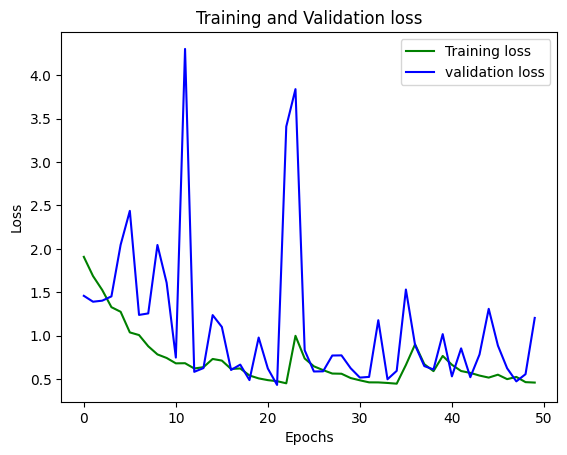

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

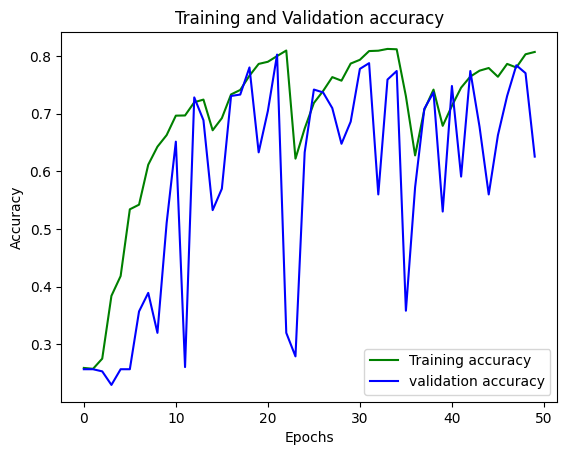

In [ ]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('my_model.keras')

In [ ]:
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#Image path
path = Path('dataset/ModerateDemented/moderateDem0.jpg')
img = image.load_img(path, target_size=(176,176))
image_array = img_to_array(img) / 255.0
image_array = np.expand_dims(image_array, axis=0)

img_array = image_array.reshape((1, 176, 176, 3))
k

predictions = model.predict(image_array)

#print(predictions)
predicted_label = train_labels[np.argmax(predictions)]

NameError: name 'image' is not defined

In [ ]:
# prompt: how to check the accuracy of this model

# ... (Your existing code) ...

loss, accuracy, auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("AUC: ", auc) # Print the AUC score

# ... (rest of your code)

NameError: name 'model' is not defined

In [ ]:
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np
from streamlit_option_menu import option_menu
import re
import base64
from fpdf import FPDF

import mysql.connector

# Connect to the MySQL database
try:
    mydb = mysql.connector.connect(
        host="localhost",
        user="",
        password="",
        database="Alzheimers"
    )
    print("Database connection successful")
except mysql.connector.Error as err:
    print("Error connecting to database:", err)
    exit(1)
# Get a cursor object to execute SQL queries
mycursor = mydb.cursor()




st.markdown("""
<style>
    button.step-up {display: none;}
    button.step-down {display: none;}
    div[data-baseweb] {border-radius: 4px;}
</style>""",
unsafe_allow_html=True)

def get_base64(bin_file):
    with open(bin_file, 'rb') as f:
        data = f.read()
    return base64.b64encode(data).decode()

def set_background(png_file):
    bin_str = get_base64(png_file)
    page_bg_img = '''
    <style>
    .stApp {
    background-image: url("data:image/png;base64,%s");
    background-position: center;
    background-size: cover;
    }
    </style>
    ''' % bin_str
    st.markdown(page_bg_img, unsafe_allow_html=True)
set_background('./images/bg3.png')

# Load the saved model
model = tf.keras.models.load_model('model.h5')

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented',
                'Non Demented', 'Very Mild Demented']

# Define the function to preprocess the image


def preprocess_image(image):
    image = image.convert('RGB')
    image = image.resize((176, 176))
    image = np.array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Define the Streamlit app

def validate_phone_number(phone_number):
    """
    Validates that a phone number is a 10-digit number.
    """
    pattern = r'^\d{10}$'
    contact=re.match(pattern, str(phone_number))
    if not contact:
        st.error('Please enter a 10 digit number!')
        return False
    return True

def validate_name(name):
    if not all(char.isalpha() or char.isspace() for char in name):
        st.error("Name should not contain numbers or special character.")
        return False
    return True

def validate_input(name, age,contact,file):
    if not name:
        st.error('Please enter the patients name!')
        return False
    if not age:
        st.error('Please enter your age!')
        return False
    if not contact:
        st.error('Please enter your contact number!')
        return False
    if not file:
        st.error('Please upload the MRi Scan!')
        return False
    return True
#with st.sidebar:
selected = option_menu(
            menu_title=None,  # required
            options=["Home", "Alzhiemer Detection", "About US"],  # required
            icons=["house", "book", "envelope"],  # optional
            menu_icon="cast",  # optional
            default_index=0,  # optional
            orientation="horizontal",
        )
if selected =='Home':
    def app():
     st.title("Alzheimer's Disease")
     st.write("Alzheimer disease is the most common type of dementia. It is a progressive disease beginning with mild memory loss and possibly leading to loss of the ability to carry on a conversation and respond to the environment. Alzheimer disease involves parts of the brain that control thought, memory, and language.")
     st.write("Using this website, you can find out that does your MRI scan have Alzheimer's disease. It is classified according to four different stages of Alzheimer's disease.")
     st.write('1. Mild Demented')
     st.write("2. Very Mild Demented")
     st.write("3. Moderate Demented")
     st.write("4. Non Demented")

if selected =='About US':
    def app():
        st.title('Welcome!')
        st.write('This web app uses a CNN model to recognize the presence of Alzheimer diasease in any age group. Leaving behind the traditional method of MRI Scans you can now get yourself checked through our protable web APP and you can get your report within no time.')
        st.write('This web app is a MINi Project made by Shubham Shinde')

if selected=='Alzhiemer Detection':
  def app():
    st.title('Alzheimer Detection Web App')
    st.write('Please enter your personal details along with MRI scan.')

    # Add fields for name, age, contact, and gender
    with st.form(key='myform', clear_on_submit=True):
        name = st.text_input('Name')
        age = st.number_input('Age', min_value=1, max_value=150, value=40)
        gender = st.radio('Gender', ('Male', 'Female','Other'))
        contact = st.text_input('Contact Number', value='', key='contact')

        file = st.file_uploader('Upload an image', type=['jpg', 'jpeg', 'png'])
        submit=st.form_submit_button("Submit")

        # Define a function to insert the form data into the `prediction` table
    def insert_data(name, age, gender, contact, prediction):
        try:
          sql = "INSERT INTO predictions (Patient_Name, Age, Gender, Contact, Prediction) VALUES (%s, %s, %s, %s, %s)"
          val = (name, age, gender, contact, prediction)
          mycursor.execute(sql, val)
          mydb.commit()
          print(mycursor.rowcount, "record inserted")
        except mysql.connector.Error as err:
          print("Error inserting record:", err)


    if file is not None and validate_input(name, age,contact,file) and validate_phone_number(contact) and validate_name(name):
                  st.success('Your personal information has been recorded.', icon="✅")
                  image = Image.open(file)
                  png_image = image.convert('RGBA')
                  st.image(image, caption='Uploaded Image', width=200)
                  # Use the fields for name, age, contact, and gender in the output

                  st.write('Name:', name)
                  st.write('Age:', age)
                  st.write('Gender:', gender)
                  st.write('Contact:', contact)
                  image = preprocess_image(image)
                  prediction = model.predict(image)
                  prediction = np.argmax(prediction, axis=1)
                  st.success('The predicted class is: '+ class_labels[prediction[0]])
                  result_str = 'Name: {}\nAge: {}\nGender: {}\nContact: {}\nPrediction for Alzheimer: {}'.format(
                     name, age, gender, contact, class_labels[prediction[0]])
                  insert_data(name, age, gender, contact, class_labels[prediction[0]])
                  export_as_pdf = st.button("Export Report")

                  def create_download_link(val, filename):
                    b64 = base64.b64encode(val)  # val looks like b'...'
                    return f'<a href="data:application/octet-stream;base64,{b64.decode()}" download="{filename}.pdf">Download file</a>'

                  if export_as_pdf:
                     pdf = FPDF()
                     pdf.add_page()
                     # set the border style
                     pdf.set_draw_color(0, 0, 0)
                     pdf.set_line_width(1)

                     # add a border to the entire page
                     pdf.rect(5.0, 5.0, 200.0, 287.0, 'D')

                     # Set font for title
                     pdf.set_font('Times', 'B', 24)
                     pdf.cell(200, 20, 'Alzheimer Detection Report', 0, 1, 'C')

                     # Set font for section headers
                     pdf.set_font('Arial', 'B', 16)
                     pdf.cell(200, 10, 'Patient Details', 0, 1)

                     # Set font for regular text
                     pdf.set_font('Arial', '', 12)
                     pdf.cell(200, 10, f'Name: {name}', 0, 1)
                     pdf.cell(200, 10, f'Age: {age}', 0, 1)
                     pdf.cell(200, 10, f'Gender: {gender}', 0, 1)
                     pdf.cell(200, 10, f'Contact: {contact}', 0, 1)
                     pdf.ln(0.15)
                     pdf.ln(0.15)



                     # Add the image to the PDF object's images dictionary
                     png_file = "image.png"
                     png_image.save(png_file, "PNG")
                     pdf.cell(200, 10, 'MRI scan:', 0, 1)
                     pdf.image(png_file, x=40, y=80, w=50,h=50)
                     pdf.ln(0.15)
                     pdf.ln(10.0)
                     pdf.ln(10.0)
                     pdf.ln(10.15)
                     pdf.ln(10.15)
                     pdf.ln(1.15)
                     pdf.ln(1.15)
                     pdf.ln(1.15)

                     # Set font for prediction text
                     pdf.set_font('Arial', 'B', 16)
                     pdf.cell(200, 10, f'Prediction for Alzheimer: {class_labels[prediction[0]]}', 0, 1)
                     pdf.ln(2.0)
                     pdf.set_font('Arial', 'B', 12)
                     if (prediction!=2):
                      pdf.set_text_color(255, 0, 0)
                      pdf.cell(200,10,'Demetia detected in your MRI, kindly consult a nearby neurologist immediately!',0,1)
                      pdf.set_text_color(0, 0, 255)
                      pdf.set_font('Arial', 'B', 10)
                      pdf.cell(200, 10, 'Here are some precautions you can take:', 0, 1, 'C')
                      pdf.ln(2)

                      precautions = [
                        '1. Stay mentally active: Engage in mentally stimulating activities such as reading, writing, puzzles, and games to keep your brain active.',
                        '2. Stay physically active: Exercise regularly to improve blood flow to the brain and help prevent cognitive decline.',
                        '3. Eat a healthy diet: Eat a balanced diet that is rich in fruits, vegetables, whole grains, and lean protein to help maintain brain health.',
                        '4. Stay socially active: Engage in social activities and maintain social connections to help prevent social isolation and depression.',
                        '5. Get enough sleep: Aim for 7-8 hours of sleep per night to help improve brain function and prevent cognitive decline.'                ]

                      pdf.set_font('Arial', '', 12)

                      for precaution in precautions:
                       pdf.multi_cell(190, 10, precaution, 0, 1, 'L')
                       pdf.ln(1)

                     else:
                       pdf.set_text_color(0, 255, 0)
                       pdf.cell(200,10,'Congratulations! There is no sign of demetia in your MRI.',0,1)

                      # Create and display the download link
                     html = create_download_link(pdf.output(dest="S").encode("latin-1"), "test")
                     st.markdown(html, unsafe_allow_html=True)





# Run the app
if __name__ == '__main__':
    app()

ModuleNotFoundError: No module named 'streamlit'